# Experiment: Forward Selection (SequentialFeatureSelector + LogisticRegression)

Task: **classification**

Forward selection runs in the post-encoded feature space; it may be slow.

In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

SEED = 42
np.random.seed(SEED)

REPO_ROOT = Path.cwd().resolve().parents[0]  # notebooks/ -> repo root
sys.path.insert(0, str(REPO_ROOT))

PREPROCESSED_ROOT = REPO_ROOT / 'data' / '02-preprocessed'
BASELINE_CONFIG_JSON = REPO_ROOT / 'config' / 'baseline_feature_config.json'

prepared_dirs = sorted([p for p in PREPROCESSED_ROOT.iterdir() if p.is_dir()], key=lambda p: p.name)
if not prepared_dirs:
    raise FileNotFoundError(f'No prepared datasets found under: {PREPROCESSED_ROOT}')
DATASET_DIR = prepared_dirs[-1]

cleaned_parquet = DATASET_DIR / 'cleaned.parquet'
cleaned_csv = DATASET_DIR / 'cleaned.csv'
split_csv = DATASET_DIR / 'split.csv'

print(f'Using prepared dataset: {DATASET_DIR}')
print(f'Using baseline config:  {BASELINE_CONFIG_JSON}')

if cleaned_parquet.exists():
    df = pd.read_parquet(cleaned_parquet)
elif cleaned_csv.exists():
    df = pd.read_csv(cleaned_csv)
else:
    raise FileNotFoundError('Expected cleaned.parquet or cleaned.csv')

splits = pd.read_csv(split_csv)

from src.pipelines.features import apply_baseline_feature_config, load_baseline_feature_config
cfg = load_baseline_feature_config(BASELINE_CONFIG_JSON)

required_cols = {cfg.row_id_col, cfg.target_col}
missing_required = required_cols - set(df.columns)
if missing_required:
    raise KeyError(f'Missing required columns in cleaned data: {sorted(missing_required)}')

X_full = apply_baseline_feature_config(df, cfg)
y_full = df[cfg.target_col].astype(str)

df_split = df[[cfg.row_id_col]].merge(splits[[cfg.row_id_col, 'split']], on=cfg.row_id_col, how='left')
if df_split['split'].isna().any():
    raise ValueError('Some rows are missing split assignments (split.csv join failed)')

mask_train = df_split['split'].eq('train')
mask_val = df_split['split'].eq('val')
mask_test = df_split['split'].eq('test')

X_train, y_train = X_full.loc[mask_train].reset_index(drop=True), y_full.loc[mask_train].reset_index(drop=True)
X_val, y_val = X_full.loc[mask_val].reset_index(drop=True), y_full.loc[mask_val].reset_index(drop=True)
X_test, y_test = X_full.loc[mask_test].reset_index(drop=True), y_full.loc[mask_test].reset_index(drop=True)

print('Split sizes:', X_train.shape, X_val.shape, X_test.shape)


Using prepared dataset: C:\repos\ml-cybersecurity_attacks\data\02-preprocessed\cybersecurity_attacks_v1_2025-12-29
Using baseline config:  C:\repos\ml-cybersecurity_attacks\config\baseline_feature_config.json
Split sizes: (28000, 25) (6000, 25) (6000, 25)


In [2]:
# Build preprocessing: impute + one-hot for categoricals; impute (+ optional scale) for numeric

cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object' or str(X_train[c].dtype).startswith('string')]
num_cols = [c for c in X_train.columns if c not in cat_cols]

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

num_steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
]
num_steps = [s for s in num_steps if not (isinstance(s, str) or s[0].startswith('#'))]
num_pipe = Pipeline(steps=num_steps)

preprocess = ColumnTransformer(
    transformers=[('cat', cat_pipe, cat_cols), ('num', num_pipe, num_cols)],
    remainder='drop',
)

print(f'Categorical cols: {len(cat_cols)}')
print(f'Numeric cols:     {len(num_cols)}')


Categorical cols: 11
Numeric cols:     14


In [4]:
# Model definition + training

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import clone

base = LogisticRegression(max_iter=2000, class_weight='balanced')

# Select features after preprocessing (encoded feature space).
# Guard against requesting >= available features (would raise ValueError).
_preprocess_probe = clone(preprocess)
X_train_enc = _preprocess_probe.fit_transform(X_train, y_train)
n_encoded_features = int(getattr(X_train_enc, 'shape', [0, 0])[1])
n_select = min(50, max(1, n_encoded_features - 1))
print(f'Encoded features: {n_encoded_features}; selecting: {n_select}')

sfs = SequentialFeatureSelector(base, n_features_to_select=n_select, direction='forward', n_jobs=-1)

# Single pipeline so feature selection runs on encoded columns
clf = Pipeline(steps=[('preprocess', preprocess), ('sfs', sfs), ('lr', base)])
clf.fit(X_train, y_train)


Encoded features: 38; selecting: 37


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('sfs', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [6]:
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, f1_score

def eval_split(name: str, y_true, y_pred) -> None:
    print(f'\n== {name} ==')
    print('macro_f1:', f1_score(y_true, y_pred, average='macro'))
    print('weighted_f1:', f1_score(y_true, y_pred, average='weighted'))
    print('balanced_acc:', balanced_accuracy_score(y_true, y_pred))
    print('confusion_matrix:\n', confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

val_pred = clf.predict(X_val)
test_pred = clf.predict(X_test)

eval_split('val', y_val, val_pred)
eval_split('test', y_test, test_pred)



== val ==
macro_f1: 0.32765084149064055
weighted_f1: 0.32763330325827633
balanced_acc: 0.3278941937542961
confusion_matrix:
 [[618 710 686]
 [632 648 710]
 [604 691 701]]
              precision    recall  f1-score   support

        DDoS       0.33      0.31      0.32      2014
   Intrusion       0.32      0.33      0.32      1990
     Malware       0.33      0.35      0.34      1996

    accuracy                           0.33      6000
   macro avg       0.33      0.33      0.33      6000
weighted avg       0.33      0.33      0.33      6000


== test ==
macro_f1: 0.3451227320941275
weighted_f1: 0.3451241205836124
balanced_acc: 0.3451952961195446
confusion_matrix:
 [[674 669 671]
 [622 681 687]
 [611 669 716]]
              precision    recall  f1-score   support

        DDoS       0.35      0.33      0.34      2014
   Intrusion       0.34      0.34      0.34      1990
     Malware       0.35      0.36      0.35      1996

    accuracy                           0.35      6000
   m

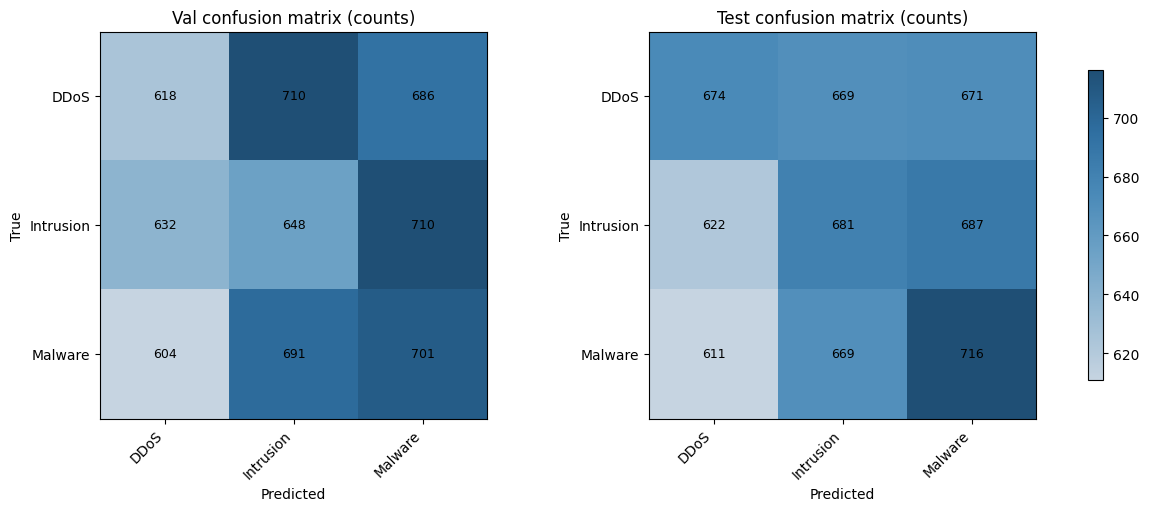

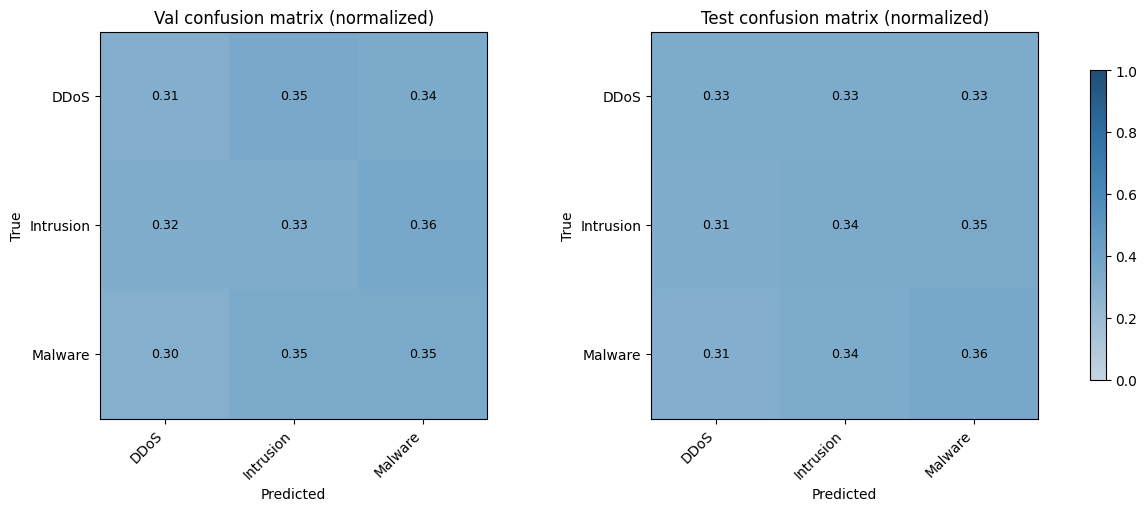

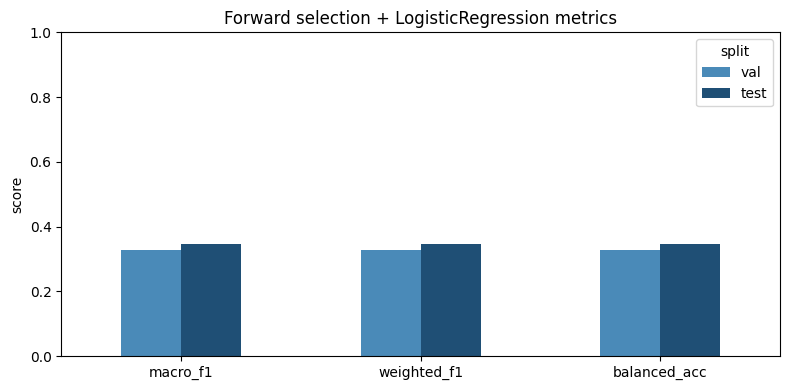

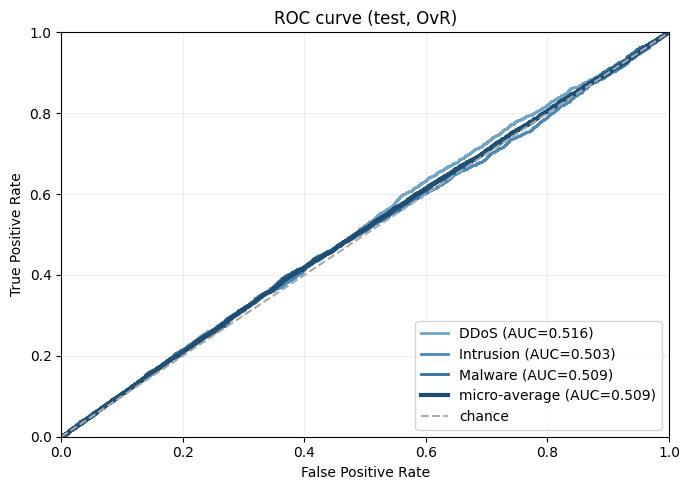

In [9]:
# Charts: confusion matrices + metrics + ROC (uses config visualization palette)

import json
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import label_binarize

# Load palette from config and expose it as `color_pallete` (spelling per request)
viz_cfg = json.loads((REPO_ROOT / 'config' / 'visualization.json').read_text(encoding='utf-8'))
color_pallete = viz_cfg['visualization']['color_palette']

labels = sorted(pd.unique(pd.concat([y_train, y_val, y_test], ignore_index=True)))

def _metrics(y_true, y_pred) -> dict:
    return {
        'macro_f1': float(f1_score(y_true, y_pred, average='macro')),
        'weighted_f1': float(f1_score(y_true, y_pred, average='weighted')),
        'balanced_acc': float(balanced_accuracy_score(y_true, y_pred)),
    }

def _normalize_rows(cm: np.ndarray) -> np.ndarray:
    cm = cm.astype(float)
    row_sums = cm.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    return cm / row_sums

val_cm = confusion_matrix(y_val, val_pred, labels=labels)
test_cm = confusion_matrix(y_test, test_pred, labels=labels)

val_metrics = _metrics(y_val, val_pred)
test_metrics = _metrics(y_test, test_pred)

cm_cmap = LinearSegmentedColormap.from_list('repo_palette', color_pallete[:6])

# Confusion matrices (counts)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
for ax, cm, title in zip(axes, [val_cm, test_cm], ['Val confusion matrix (counts)', 'Test confusion matrix (counts)']):
    im = ax.imshow(cm, cmap=cm_cmap)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(int(v)), ha='center', va='center', fontsize=9)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()

# Confusion matrices (normalized, row-wise)
val_cm_n = _normalize_rows(val_cm)
test_cm_n = _normalize_rows(test_cm)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
for ax, cm, title in zip(axes, [val_cm_n, test_cm_n], ['Val confusion matrix (normalized)', 'Test confusion matrix (normalized)']):
    im = ax.imshow(cm, cmap=cm_cmap, vmin=0.0, vmax=1.0)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, f'{v:.2f}', ha='center', va='center', fontsize=9)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()

# Metrics bar chart
metrics_df = pd.DataFrame([val_metrics, test_metrics], index=['val', 'test']).T
ax = metrics_df.plot(kind='bar', figsize=(8, 4), color=[color_pallete[3], color_pallete[5]], rot=0)
ax.set_title('Forward selection + LogisticRegression metrics')
ax.set_ylabel('score')
ax.set_ylim(0, 1)
ax.legend(title='split')
plt.tight_layout()
plt.show()

# ROC curve (one-vs-rest, using predicted probabilities)
if not hasattr(clf, 'predict_proba'):
    raise AttributeError('Pipeline does not support predict_proba; ROC requires probability scores')

y_test_proba = clf.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=labels)

plt.figure(figsize=(7, 5))
for i, cls in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=color_pallete[(i + 2) % len(color_pallete)], label=f'{cls} (AUC={roc_auc:.3f})')

# micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_proba.ravel())
auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, lw=3, color=color_pallete[5], label=f'micro-average (AUC={auc_micro:.3f})')

# diagonal baseline
plt.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color=color_pallete[7], label='chance')

plt.title('ROC curve (test, OvR)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()
